# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs

In [2]:
#Node table
#key = node id, value = (x,y)
node_table = {
    1:  (0,0),
    2:  (0,1),
    3:  (0,2),
    4:  (1,0),
    5:  (1,0.5),
    6:  (1,1.5),
    7:  (1,2),
    8:  (2,0),
    9:  (2,1),
    10: (2,2),
    11: (3,0),
    12: (3,0.5),
    13: (3,1.5),
    14: (3,2)
}

In [3]:
#Connectivity table
#key = element id, value = (node1_id, node2_id, node3_id)
connectivity_table = {
    1:  (1,2,5),
    2:  (2,3,6),
    3:  (2,5,6),
    4:  (1,4,5),
    5:  (3,6,7),
    6:  (6,7,10),
    7:  (6,9,10),
    8:  (5,6,9),
    9:  (5,8,9),
    10: (4,5,8),
    11: (8,11,12),
    12: (8,9,12),
    13: (9,12,13),
    14: (9,10,13),
    15: (10,13,14)
}

In [4]:
#Temperature boundary conditions
#key = node id, value = node temperature
boundary_temperatures = {
    1:  200,
    2:  200,
    3:  200,
    11: 25,
    12: 25,
    13: 25,
    14: 25
}

#Flux boundary conditions
#key = node id, value = node flux
boundary_fluxes = {
    4:  0,
    7:  0,
    8:  0,
    10: 0
}

In [5]:
#Parameters
k = 45 #Thermal conductivity
Q = 0  #Heat source

# Classes

In [6]:
class Node:
    def __init__(self, id, x, y, T=None, q=None):
        self.id = id
        self.x  = x
        self.y  = y
        self.T  = T
        self.q  = q
    
    def __repr__(self):
        return f"Node({self.id}, x={self.x}, y={self.y}, T={self.T})"
    
    def setTemperature(self, T):
        self.T = T
    
    def setFlux(self, q):
        self.q = q

In [7]:
class Element:
    def __init__(self, id, nodes):
        self.id = id
        self.nodes = nodes
        self.coords = self.coordinates()  

    def __repr__(self):
        node_ids = [node.id for node in self.nodes]  
        return f"Element(id={self.id}, nodes={node_ids})"
    
    def coordinates(self):
        return np.array([(node.x, node.y) for node in self.nodes])
    
    def area(self):
        # Use stored coords
        area_array = np.array([
            [1, self.coords[0, 0], self.coords[0, 1]],
            [1, self.coords[1, 0], self.coords[1, 1]],
            [1, self.coords[2, 0], self.coords[2, 1]]
        ])
        return 0.5 * np.abs(np.linalg.det(area_array))
    
    def B(self):
        b1 = self.coords[1, 1] - self.coords[2, 1]
        b2 = self.coords[2, 1] - self.coords[0, 1]
        b3 = self.coords[0, 1] - self.coords[1, 1]
        c1 = self.coords[2, 0] - self.coords[1, 0]
        c2 = self.coords[0, 0] - self.coords[2, 0]
        c3 = self.coords[1, 0] - self.coords[0, 0]
        return np.array([[b1, b2, b3], [c1, c2, c3]])
    
    def localStiffnessMatrix(self):
        return k * 1 / (4 * self.area()) * self.B().T @ self.B()

In [8]:
class Mesh:
    def __init__(self, nodes, elements):
        self.nodes = nodes
        self.elements = elements
    
    def plot_mesh(mesh, display_temp=False):
        plt.figure(figsize=(8, 6))
        
        # Plot each element
        for element in mesh.elements.values():
            # Get the coordinates of the nodes
            coords = np.array([(node.x, node.y) for node in element.nodes])
            # Close the polygon by appending the first node again
            coords = np.vstack([coords, coords[0]])
            plt.plot(coords[:, 0], coords[:, 1], marker='o')

        #Plot boundary temperatures
        if display_temp == True:
            for node_id, node in mesh.nodes.items():
                temp = node.T
                node = mesh.nodes[node_id]
                plt.text(node.x, node.y, f'T={temp:.3g}', fontsize=9, ha='right')

        # Set labels and title
        plt.title('Finite Element Mesh')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# Mesh Generation

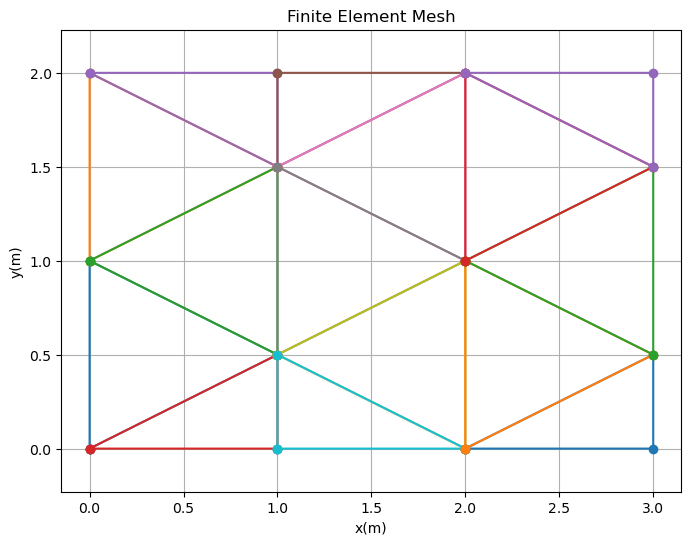

In [9]:
#mesh generation
n_nodes = len(node_table)
n_elements = len(connectivity_table)
n_nodes_per_element = 3
nodes = {}
elements = {}

#generate nodes
for node_id, coordinates in node_table.items():
    nodes[node_id] = Node(node_id, coordinates[0], coordinates[1]) 

#generate elements  
for element_id, nodes_ids in connectivity_table.items():
    element_nodes = []
    for node_id in nodes_ids:
        element_nodes.append(nodes[node_id])
    elements[element_id] = Element(element_id, element_nodes)

#generate mesh
mesh = Mesh(nodes, elements)
#plot mesh
mesh.plot_mesh()

# Assembly

In [10]:
#Global stiffness matrix and global load vector
K_global = np.zeros((n_nodes, n_nodes))
R_global = np.zeros(n_nodes)
N_local_nodes = 3
#loop over all elements
for element in mesh.elements.values():
    k_local = element.localStiffnessMatrix()
    local_indices = [node.id - 1 for node in element.nodes] #adjust for zero indexing of global matrix

    for i in range(N_local_nodes):
        for j in range(N_local_nodes):
            K_global[local_indices[i], local_indices[j]] += k_local[i,j]

# Boundary Conditions

In [11]:
#Dirchlet
n_dirichlet_nodes = len(boundary_temperatures)
node_ids = np.arange(0, n_nodes)
dirchlet_node_ids =  np.array(list(boundary_temperatures.keys())) - 1  #adjust for zero indexing
non_dirichlet_node_ids = np.setdiff1d(node_ids, dirchlet_node_ids)
n_dirchlet_node_ids = len(dirchlet_node_ids)
n_interior_nodes = n_nodes - n_dirchlet_node_ids
#reducing global stiffness matrix
reduced_K_global = np.zeros((n_interior_nodes, n_interior_nodes))
temporary_K_global = np.delete(K_global, dirchlet_node_ids, 0) #remove rows
reduced_K_global = np.delete(temporary_K_global, dirchlet_node_ids, 1) #remove columns 
reduced_R_global = np.delete(R_global, dirchlet_node_ids)

R_modifier = np.zeros(n_nodes)
#modifying global load vector with boundary temperatures
for node_id, temperature in boundary_temperatures.items():
    node_id -= 1 #adjust for zero indexing
    R_modifier += K_global[:,node_id] * temperature

reduced_R_global -= np.delete(R_modifier, dirchlet_node_ids)

# Solve

In [12]:
unkown_temperatures = np.linalg.solve(reduced_K_global, reduced_R_global) #solve for unkown temperatures
#construct full temperature vector
temperature = np.zeros(n_nodes)
i = 0
for node_id in non_dirichlet_node_ids:
    temperature[node_id] = unkown_temperatures[i]
    i += 1
#add boundary temperatures to full temperature vector
for node_id, boundary_temperature in boundary_temperatures.items():
    node_id -= 1 #adjust for zero indexing
    temperature[node_id] = boundary_temperature

for node in mesh.nodes.values():
    node.setTemperature(temperature[node.id-1])

# Output

Node ID    Temperature (degC)
-------------------------
1          200            
2          200            
3          200            
4          142            
5          142            
6          142            
7          142            
8          83.3           
9          83.3           
10         83.3           
11         25             
12         25             
13         25             
14         25             


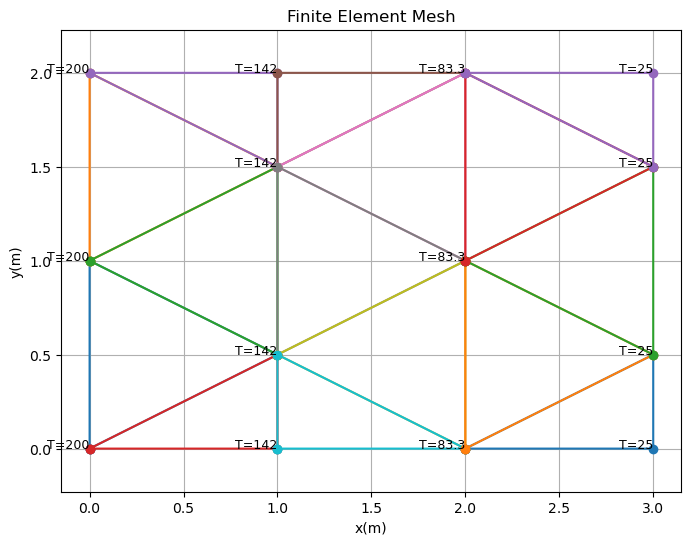

In [13]:
print(f"{'Node ID':<10} {'Temperature (degC)':<15}")
print("-" * 25)
for node_id, node in mesh.nodes.items():
    temp_formatted = f"{mesh.nodes[node_id].T:.3g}"  # .3g for 3 significant figures
    print(f"{node_id:<10} {temp_formatted:<15}")
mesh.plot_mesh(display_temp=True)